In [36]:
import cv2
import mediapipe as mp
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check foot landing on plank and gaze direction
def foot_lands_on_plank_and_no_gaze(foot, plank_threshold, nose, board_threshold):
    """
    Determines if the foot lands on the white plank and the athlete's gaze 
    is not directed at the board.
    Conditions:
    - The foot should be within a specified horizontal threshold (x-axis).
    - The gaze should not be directed downward at the board.
    """
    foot_x, _ = foot
    nose_x, nose_y = nose

    foot_on_plank = abs(foot_x - plank_threshold) < 0.05  # Foot position threshold
    no_gaze_at_board = nose_y > board_threshold  # Gaze should not be downward

    return foot_on_plank and no_gaze_at_board

# Paths for the distance jump videos and keypoints storage
stage_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/distance_jump/stages/stage2/videos"
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/distance_jump/stages/stage2/keypoints"

# Ensure keypoints folder exists
os.makedirs(keypoints_folder, exist_ok=True)

# Define thresholds (adjust based on environment)
plank_threshold = 0.5  # Example normalized x-coordinate for the white plank
board_threshold = 0.3  # Example normalized y-coordinate for the board

for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []  # Store keypoints for this video

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB for MediaPipe processing
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract relevant keypoints (feet and nose)
                left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y]
                right_foot = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x,
                              landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y]
                nose = [landmarks[mp_pose.PoseLandmark.NOSE].x,
                        landmarks[mp_pose.PoseLandmark.NOSE].y]

                # Determine foot landing and gaze direction
                left_condition = foot_lands_on_plank_and_no_gaze(left_foot, plank_threshold, nose, board_threshold)
                right_condition = foot_lands_on_plank_and_no_gaze(right_foot, plank_threshold, nose, board_threshold)

                # Store data for this frame
                keypoints_data.append({
                    "frame": int(cap.get(cv2.CAP_PROP_POS_FRAMES)),
                    "left_foot_on_plank_no_gaze": left_condition,
                    "right_foot_on_plank_no_gaze": right_condition,
                    "left_foot": left_foot,
                    "right_foot": right_foot,
                    "nose": nose
                })

        cap.release()

        # Save keypoints to the keypoints folder
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_path = os.path.join(keypoints_folder, json_filename)
        with open(json_path, "w") as json_file:
            json.dump(keypoints_data, json_file, indent=4)

print("Foot landing and gaze analysis complete! JSON files saved in 'keypoints' folder.")

I0000 00:00:1737739784.225625 12919892 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737739784.281713 12976748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737739784.290061 12976756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Foot landing and gaze analysis complete! JSON files saved in 'keypoints' folder.


In [38]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path to the keypoints folder for foot landing and gaze analysis
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/distance_jump/stages/stage2/keypoints"

# Lists to store sequences and labels
sequences = []
labels = []

# Process keypoint JSON files
for file in os.listdir(keypoints_folder):
    if file.endswith("_keypoints.json"):
        file_path = os.path.join(keypoints_folder, file)
        
        with open(file_path, "r") as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                print(f"Error loading JSON from {file}")
                continue

        # Ensure data is in expected format
        if isinstance(data, list):
            foot_gaze_data = [
                [
                    int(frame.get("left_foot_on_plank_no_gaze", 0)),
                    int(frame.get("right_foot_on_plank_no_gaze", 0))
                ]
                for frame in data if isinstance(frame, dict)
            ]
            sequences.append(foot_gaze_data)
        else:
            print(f"Unexpected format in {file}, skipping.")
            continue

        # Extract label from filename (assumes label is the first part of filename)
        try:
            label = float(file.split("_")[0])  # Modify if filename structure differs
            labels.append(label)
        except ValueError:
            print(f"Warning: Unable to extract label from {file}")
            continue

# Pad sequences to the same length
if sequences:
    max_len = max(len(seq) for seq in sequences)
    sequences = pad_sequences(sequences, maxlen=max_len, padding='post', dtype='float32')
    labels = np.array(labels)

    print(f"Loaded {len(sequences)} sequences with labels.")
else:
    print("No sequences found in the keypoints folder.")

Loaded 15 sequences with labels.


In [39]:
def augment_data(sequence):
    augmented_sequences = []

    # Original
    augmented_sequences.append(sequence)

    # Mirrored (flip angles horizontally)
    mirrored = -sequence
    augmented_sequences.append(mirrored)

    # Rotation (add a small angle offset)
    rotated = sequence + np.random.uniform(-10, 10, size=sequence.shape)
    augmented_sequences.append(rotated)

    # Noise (add random Gaussian noise)
    noisy = sequence + np.random.normal(0, 0.05, size=sequence.shape)
    augmented_sequences.append(noisy)

    # Scaled (adjust by a small percentage)
    scaled = sequence * np.random.uniform(0.9, 1.1)
    augmented_sequences.append(scaled)

    return augmented_sequences

augmented_sequences = []
augmented_labels = []

for seq, label in zip(sequences, labels):
    augmented = augment_data(seq)
    augmented_sequences.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

print(f"Augmented dataset size: {len(augmented_sequences)}")

Augmented dataset size: 75


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    augmented_sequences, augmented_labels, test_size=4/17, random_state=42
)

# Ensure correct shape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 2))

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 57, Validation samples: 18


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define enhanced LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 2))),
    Dropout(0.5),
    Bidirectional(LSTM(32, activation='tanh', return_sequences=False)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output: Regression score
])

# Compile the model with a reduced learning rate for better convergence
model.compile(optimizer=Adam(learning_rate=0.00075), loss='mse', metrics=['mae'])

print(model.summary())


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [42]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,  # You can adjust based on convergence
    batch_size=16,  # Smaller batch size for augmented data
    verbose=1
)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.6906 - mae: 0.7259 - val_loss: 0.7282 - val_mae: 0.7949
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6278 - mae: 0.7282 - val_loss: 0.6148 - val_mae: 0.7435
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4550 - mae: 0.5976 - val_loss: 0.4740 - val_mae: 0.6554
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3329 - mae: 0.5237 - val_loss: 0.3176 - val_mae: 0.5216
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2415 - mae: 0.4490 - val_loss: 0.2018 - val_mae: 0.3985
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1675 - mae: 0.3545 - val_loss: 0.1439 - val_mae: 0.3146
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1705 - mae: 0.3271 - val_loss: 0.1437 - val_mae: 0.3273
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1650 - mae: 0.3402 - val_loss: 0.1580 - val_mae: 0.3556
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1843 - mae: 

In [43]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.1572, Validation MAE: 0.3166


In [44]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Print predictions vs. actual
for i, pred in enumerate(predictions):
    print(f"Predicted: {pred[0]:.2f}, Actual: {y_val[i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Predicted: 0.79, Actual: 1.00
Predicted: 0.85, Actual: 1.00
Predicted: 0.79, Actual: 1.00
Predicted: 0.79, Actual: 1.00
Predicted: 0.79, Actual: 1.00
Predicted: 0.79, Actual: 1.00
Predicted: 0.91, Actual: 1.00
Predicted: 1.07, Actual: 1.00
Predicted: 0.79, Actual: 1.00
Predicted: 0.79, Actual: 1.00
Predicted: 0.79, Actual: 1.00
Predicted: 0.67, Actual: 0.00
Predicted: 0.79, Actual: 0.00
Predicted: 0.60, Actual: 0.00
Predicted: 0.79, Actual: 1.00
Predicted: 0.09, Actual: 1.00
Predicted: 0.79, Actual: 1.00
Predicted: 0.70, Actual: 1.00


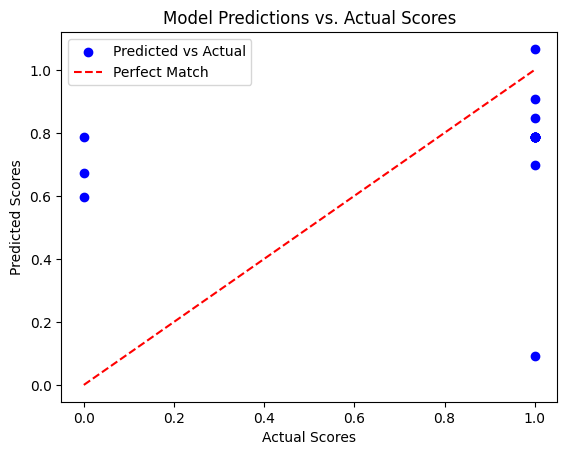

In [45]:
# Scatter plot of predictions vs. actual
import matplotlib.pyplot as plt

plt.scatter(y_val, predictions, c='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Model Predictions vs. Actual Scores')
plt.legend()
plt.show()

In [55]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if the foot lands on the plank and no gaze at the board
def is_foot_on_plank_and_no_gaze(foot, plank_threshold, gaze_y, board_y):
    """
    Determines if the foot lands on the plank and the athlete is not looking at the board.
    Conditions:
    - Foot should be within plank threshold (x-axis).
    - Gaze (nose position) should not align with the board (y-axis).
    """
    foot_x, _ = foot
    not_gazing = gaze_y > board_y  # Checking if gaze is above the board
    foot_on_plank = foot_x < plank_threshold

    return foot_on_plank and not_gazing

# Path for the new test video
new_video_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/distance_jump/stages/stage2/test_videos/1_user13.mp4"

# Extract keypoints for the new video
new_keypoints = []
cap = cv2.VideoCapture(new_video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark

        # Extract keypoints for left and right foot and gaze (nose position)
        left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y]
        right_foot = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y]

        nose = [landmarks[mp_pose.PoseLandmark.NOSE].x,
                landmarks[mp_pose.PoseLandmark.NOSE].y]

        # Define plank position threshold (modify as needed)
        plank_threshold = 0.5
        board_y_position = 0.3  # Approximate y position of the board

        # Check foot position and gaze status
        left_foot_status = is_foot_on_plank_and_no_gaze(left_foot, plank_threshold, nose[1], board_y_position)
        right_foot_status = is_foot_on_plank_and_no_gaze(right_foot, plank_threshold, nose[1], board_y_position)

        # Store binary values (0 or 1) for both feet
        new_keypoints.append([int(left_foot_status), int(right_foot_status)])

cap.release()

# Get max_seq_length from model input shape dynamically
max_seq_length = model.input_shape[1]  # Dynamically extract sequence length from model

# Pad the sequence to match the expected input shape
new_keypoints_padded = pad_sequences([new_keypoints], maxlen=max_seq_length, padding='post', dtype='float32')

# Reshape the data to match the model's input (samples, timesteps, features)
new_keypoints_padded = new_keypoints_padded.reshape((1, max_seq_length, 2))

print(f"Final input shape for prediction: {new_keypoints_padded.shape}")

# Predict score for the new video
predicted_score = model.predict(new_keypoints_padded)
print(f"Predicted Score: {predicted_score[0][0]:.2f}")

I0000 00:00:1737739849.650281 12919892 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737739849.713721 13010766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737739849.725471 13010766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Final input shape for prediction: (1, 16, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Predicted Score: 0.87


In [47]:
print(model.input_shape)


(None, 16, 2)


In [48]:
print(X_train.shape[1])

16


In [56]:
def classify_score(prediction):
    """Classify the prediction into 0, 0.5, or 1 based on thresholds."""
    if prediction >= 0.75:
        return 1.0
    elif prediction >= 0.4:
        return 0.5
    else:
        return 0.0

In [57]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Apply classification logic
classified_predictions = [classify_score(pred[0]) for pred in predictions]

# Print classified predictions vs actual scores
for i, (pred, actual) in enumerate(zip(classified_predictions, y_val)):
    print(f"Classified: {pred}, Actual: {actual}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 0.5, Actual: 0.0
Classified: 1.0, Actual: 0.0
Classified: 0.5, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 0.5, Actual: 1.0


In [60]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    """Weighted Mean Squared Error to prioritize true negatives."""
    weights = K.switch(y_true < 0.70, 2.0, 1.0)  # Weight true negatives higher
    return K.mean(weights * K.square(y_true - y_pred))

In [61]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse, metrics=['mae'])

In [62]:
# Predict and classify scores
classified_predictions = [classify_score(pred[0]) for pred in model.predict(X_val)]

# Evaluate accuracy of classification
correct = sum(1 for pred, actual in zip(classified_predictions, y_val) if pred == actual)
accuracy = correct / len(y_val)

print(f"Classification Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Classification Accuracy: 0.72


In [63]:
model.save("/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/distance_jump/stages/stage2/models/distance_stage2.keras")